In [1]:
import pandas as pd

# Load data

In [2]:
train_df = pd.read_csv("data/train.csv", encoding="ISO-8859-1")
test_df = pd.read_csv("data/test.csv", encoding="ISO-8859-1")
attribute_df = pd.read_csv("data/attributes.csv")
product_df = pd.read_csv("data/product_descriptions.csv")

In [3]:
# train_df
# test_df
# attribute_df
# product_df

In [4]:
print train_df.columns
print test_df.columns
print attribute_df.columns
print product_df.columns

Index([u'id', u'product_uid', u'product_title', u'search_term', u'relevance'], dtype='object')
Index([u'id', u'product_uid', u'product_title', u'search_term'], dtype='object')
Index([u'product_uid', u'name', u'value'], dtype='object')
Index([u'product_uid', u'product_description'], dtype='object')


# Basic stats

In [5]:
print len(train_df)
print len(train_df["product_uid"].unique())

74067
54667


In [6]:
train_df["relevance"].unique()

array([ 3.  ,  2.5 ,  2.33,  2.67,  2.  ,  1.  ,  1.67,  1.33,  1.25,
        2.75,  1.75,  1.5 ,  2.25])

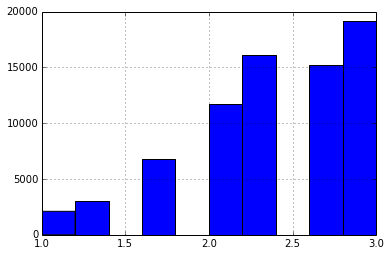

In [7]:
%matplotlib inline
train_df["relevance"].hist()

In [8]:
print len(product_df)
print len(product_df["product_uid"].unique())

124428
124428


In [9]:
print len(attribute_df)
print len(attribute_df["product_uid"].unique())

2044803
86264


In [10]:
train_df.sort_values(by="relevance", ascending=False)[0:10]  # [0:200]

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3
31037,94917,129331,National Tree Company 36 in. Mini Tea Leaf 1 B...,topiary tree,3
31070,95030,129374,HDX 2 Gal. Economy Sprayer,2 gallon sprayer,3
31069,95021,129372,Knape &amp; Vogt 18.75 in. x 14.38 in. x 22 in...,in cabinet garbage,3
31063,95008,129367,Lithonia Lighting 24 in. Replacement Lens for ...,replacement lens,3
31062,95007,129366,Classic Accessories Seasons Holiday Tree Rolli...,tree storage,3
31056,94974,129358,"Raco Single-Gang Floor Box Kit, Brass Finish w...",floor outlet,3
31055,94971,129358,"Raco Single-Gang Floor Box Kit, Brass Finish w...",electrical outlets,3
31052,94964,129355,BEHR Premium Plus #N420-6 Pine Mountain Paint,pine mountain,3
31049,94958,129353,ECHO Reconditioned 58-Volt Lithium-Ion Brushle...,echo with 4h 58 volt,3


### TEST

In [11]:
attribute_df[0:3]

,product_uid,name,value
0,100001,Bullet01,Versatile connector for various 90° connection...
1,100001,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001,Bullet03,Help ensure joints are consistently straight a...


Create an attribute_uid

In [12]:
pd.factorize(attribute_df.name)[0]

array([   0,    1,    2, ..., 1943,  928,  345])

In [13]:
attribute_df["attribute_uid"] = pd.factorize(attribute_df.name)[0]

In [14]:
attribute_df[0:3]

,product_uid,name,value,attribute_uid
0,100001,Bullet01,Versatile connector for various 90° connection...,0
1,100001,Bullet02,Stronger than angled nailing or screw fastenin...,1
2,100001,Bullet03,Help ensure joints are consistently straight a...,2


In [15]:
len(attribute_df["name"].unique())

5411

In [16]:
attribute_df.groupby("name").count().sort_values(by="value", ascending=False)[0:3]

,product_uid,value,attribute_uid
name,,,
Bullet02,86248,86248,86248
Bullet03,86226,86226,86226
MFG Brand Name,86250,86220,86250


## 1st model as simple as possible

### Train tfidf model

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
mytfidf = TfidfVectorizer(strip_accents='unicode')
myiterable = itertools.chain(train_df["product_title"], train_df["search_term"])

mytfidf.fit(myiterable)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2645: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### Apply tfidf

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
def f1(row):
    title_vec = mytfidf.transform([row['product_title']])
    query_vec = mytfidf.transform([row['search_term']])
    sim = cosine_similarity(title_vec, query_vec)
    return float(sim)

train_df["f1"] = train_df.apply(f1, axis=1)

In [ ]:
# save dataset
# with open("/home/clement/tfidf_homedepot.pkl", 'w') as fout:
#     _pickle.dump(clf, fout)

In [19]:
train_df[:3]

,id,product_uid,product_title,search_term,relevance,f1
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.0,0.304401
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.5,0.000000
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.0,0.000000


### Train our RandomForestRegressor

In [20]:
import numpy as np
seed = 42
ratio = 0.9
np.random.seed(seed)
msk = np.random.rand(len(train_df)) < ratio
training = train_df[msk]
test = train_df[~msk]

In [21]:
from sklearn.ensemble import RandomForestRegressor
mymodel = RandomForestRegressor()
mymodel.fit(X=training[["f1", "f1"]], y=training["relevance"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Apply model

In [22]:
train_df['pred'] = mymodel.predict(X=train_df[["f1", "f1"]])
training['pred'] = mymodel.predict(X=training[["f1", "f1"]])
test['pred'] = mymodel.predict(X=test[["f1", "f1"]])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### Measure performance

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#### Training

In [24]:
mse = mean_squared_error(training['relevance'], training['pred'])
rmse = sqrt(mse)
rmse

0.32764698093773964

#### Test

In [25]:
mse = mean_squared_error(test['relevance'], test['pred'])
rmse = sqrt(mse)
rmse

0.6109960729322403

## 2nd model

Pour description, title, on fait un tfidf standard  
Pour brand, on peut faire un cosine(metaphone(query), brand_value())  
Pour les autres attributs, on peut faire un *cosine(query, name) x cosine(query, value)*